# Soils

### Feng Yin
### Department of Geography, UCL
### ucfafyi@ucl.ac.uk


In this notebook, I will introduce the process of gathering soil spectra from multiple sources and interpolating them into same wavelength range (400-2500). Then the principal component analysis (PCA) is applied to derive a handful of PCs for later usage.

There is not a lot of soil spectra from a single source, and we want to have samples to cover major type of soils around the world, so we end up collecting all the available soil spectra (I can find on the internet) from different sources. Below is the list of sources:

1. [USGS spectral library](https://www.usgs.gov/energy-and-minerals/mineral-resources-program/science/usgs-high-resolution-spectral-library), V5, V6 and V7;
2. [ICRAF-ISRIC Soil VNIR Spectral Library](https://www.isric.org/explore/ISRIC-collections);
3. [Prosail soil model](https://github.com/jgomezdans/prosail/blob/master/prosail/soil_reflectance.txt);
4. [Price soil model](https://naldc.nal.usda.gov/download/37764/PDF)
5. North China plain (NCP) in-situ measurements.

So in the following processing steps, I will try to generate samples from those soil models and interpolating them to the same wavelength invertal.

In [1]:
# gp_emulator is only used to generate samples
# no actual emulation was made with it
import gp_emulator
import numpy as np
import pandas as pd
import pylab as plt
from glob import glob
from io import StringIO
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
%matplotlib inline

### USGS

In [2]:
v5s = glob('usgsSoilV5/*.asc')
v6s = glob('usgsSoilV6/*.asc')
v7s = glob('usgsSoilV7/*.txt')

#### v5

/home/ucfafyi/.conda/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice.
/home/ucfafyi/.conda/envs/py36/lib/python3.7/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/home/ucfafyi/.conda/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


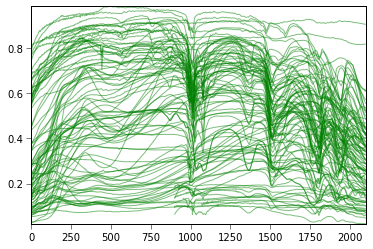

In [3]:
dats = []
for i in v5s:
    with open(i, 'r') as f:
        cont = f.read()
        cont = cont.replace('******************************', '       nan       nan')
        cont = cont.replace('***************', '       nan ')
    dat = np.loadtxt(StringIO(cont), skiprows=14)
    mask = (dat[:,0]>=0.4) & (dat[:,0]<=2.5)
    mask = mask & ((dat[:,1]>=0) & (dat[:,1]<=1))
    dat = dat[mask]
    f = interp1d(dat[:,0]*1000, dat[:,1], bounds_error=False)
    xnew = np.arange(400, 2501, 1)
    ynew = f(xnew)
    dat = np.array([xnew, ynew])
    dats.append(dat)
v5s_spec = np.array(dats)
v5s_spec[-10:] =v5s_spec[2000:2010].mean(axis=0) # avoid end with NANs
v5s_spec[v5s_spec<0] = np.nan
h = plt.plot(v5s_spec[:,1].T, 'g-', lw=1, alpha=0.5)

#### v6

/home/ucfafyi/.conda/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in less
  del sys.path[0]


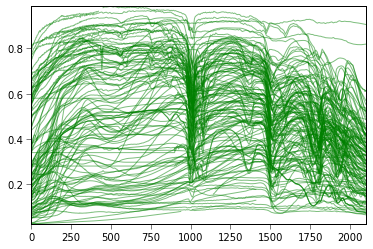

In [4]:
dats = []
for i in v6s:
    dat = np.loadtxt(i, skiprows=16)
    f = interp1d(dat[:,0]*1000, dat[:,1], bounds_error=False)
    xnew = np.arange(400, 2501, 1)
    mask = (dat[:,0]>=0.4) & (dat[:,0]<=2.5)
    mask = mask & ((dat[:,1]>=0) & (dat[:,1]<=1))
    dat = dat[mask]
    ynew = f(xnew)
    dat = np.array([xnew, ynew])
    dats.append(dat)
v6s_spec = np.array(dats)
v6s_spec[v6s_spec<0] = np.nan
h = plt.plot(v6s_spec[:,1].T, 'g-', lw=1, alpha=0.5)

It's clear that V5 and V6 data have a lot of spectra overlap each other, so we choose to use only V6 dataset.

#### v7

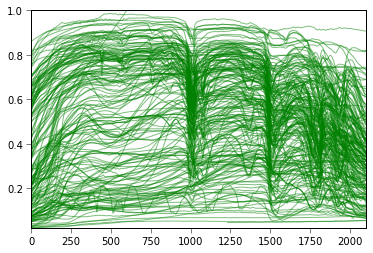

In [5]:
v7_wv = np.loadtxt('usgsSoilV7/s07_ASD_Wavelengths_ASD_0.35-2.5_microns_2151_ch.txt', skiprows=1)
dats = []
for i in v7s:
    dat = np.loadtxt(i, skiprows=1)
    mask = (dat>=0) & (dat<=1)
    dat = dat[mask]
    f = interp1d(v7_wv[mask]*1000, dat, bounds_error=False)
    xnew = np.arange(400, 2501, 1)
    ynew = f(xnew)
    dat = np.array([xnew, ynew])
    dats.append(dat)
v7s_spec = np.array(dats)
h = plt.plot(v7s_spec[:,1].T, 'g-', lw=1, alpha=0.5)

#### Putting them together

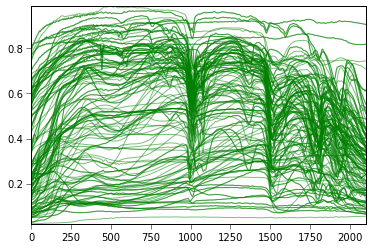

In [6]:
usgs_soil = np.vstack([v6s_spec[:,1], v7s_spec[:,1]])
# filter bad ones
bad = np.any(np.isnan(usgs_soil), axis=1)
usgs_soil = usgs_soil[~bad]
h = plt.plot(usgs_soil.T, 'g-', lw=1, alpha=0.5)

### ICRAF-ISRIC Soil VNIR Spectral Library

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


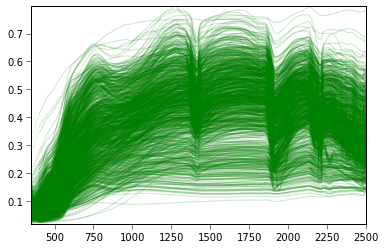

In [7]:
xls = pd.ExcelFile('ICRAF-ISRICVNIRSoilDatabaseSpectra.xls')
df = pd.read_excel(xls, 'ASD_Spectra')
wv = [float(i.split('W')[1]) for i in df.keys()[1:]]
h = plt.plot(wv, df.iloc[:, 1:].values.T, 'g-', lw=1, alpha=0.1)
f = interp1d(wv, df.iloc[:, 1:].values, bounds_error=False)
xnew = np.arange(400, 2501, 1)
isricSoil = f(xnew)
h = plt.plot(xnew, isricSoil.T, 'g-', lw=1, alpha=0.1)

### Prosail soil model

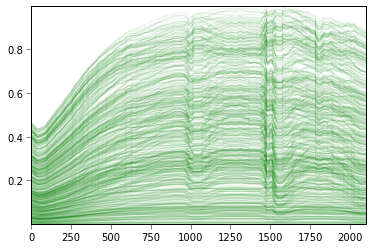

In [8]:
soil_spectrum1, soil_spectrum2 =  np.loadtxt('ProsailSoil_reflectance.txt', unpack=True)
parameters = ['rsoil', 'psoil']
p_mins = [ 0,     0]
p_maxs = [ 3,     3.]
num_samp = 1000
# gp_emulator is only used to generate samples
# no actual emulation was made with it
sample, distributions = gp_emulator.create_training_set(parameters, p_mins, p_maxs, n_train=num_samp)
rsoil, psoil = sample[:, [0]], sample[:, [1]]
# prosail soil model: rho_soil = rsoil*(psoil*soil_spectrum1+(1-psoil)*soil_spectrum2)
# https://github.com/jgomezdans/prosail
prosail_soil = rsoil*(psoil*soil_spectrum1+(1-psoil)*soil_spectrum2) 
mask = np.all(prosail_soil>=0, axis=1) & np.all(prosail_soil<=1, axis=1)
prosail_soil = prosail_soil[mask]
h = plt.plot(prosail_soil.T, 'g-', lw=1, alpha=0.1)

### Price soil model

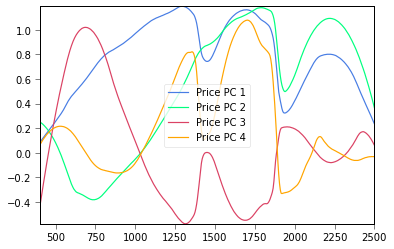

In [9]:
# load the Price soil PCs
comps = sorted(glob('Price/soil.*_component'))
s_comp = np.array([np.loadtxt(i)[:,1] for i in comps])
wv = np.loadtxt(comps[0])[:,0]

plt.plot(wv, s_comp[0], label = 'Price PC 1')
plt.plot(wv, s_comp[1], label = 'Price PC 2')
plt.plot(wv, s_comp[2], label = 'Price PC 3')
plt.plot(wv, s_comp[3], label = 'Price PC 4')
plt.legend()

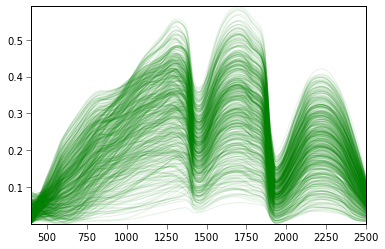

In [10]:
parameters = ['w1', 'w2','w3', 'w4']
# This range of weights are from the original (Price, 1990) paper
# but divided by 100, as the reflectance in (Price, 1990) paper
# is described by %
p_mins = [   0, -0.10, -0.10, -0.04]
p_maxs = [ 0.4,  0.10,  0.10,  0.04]
num_samp = 1000
# gp_emulator is only used to generate samples
# no actual emulation was made with it
sample, distributions = gp_emulator.create_training_set(parameters, p_mins, p_maxs, n_train=num_samp)
# Price soil model
price_soil = sample.dot(s_comp)
# mask out bad ones
mask = np.all(price_soil>=0, axis=1) & np.all(price_soil<=1, axis=1)
price_soil=  price_soil[mask]
# the interpolation
f = interp1d(wv, price_soil, bounds_error=False)
xnew = np.arange(400, 2501, 1)
ynew = f(xnew)
mask = np.all(ynew>0, axis=1) & np.all(ynew<1, axis=1)
price_soil =  ynew[mask]
h = plt.plot(xnew, price_soil.T, 'g-', lw=1, alpha=0.1)

### NCP in-situ soil measurements

(0.0, 1.0)

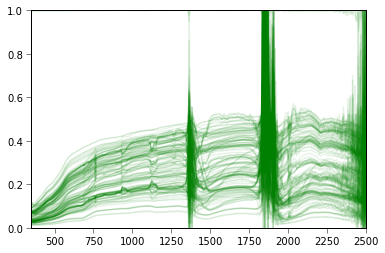

In [11]:
#load NCP data
soil = np.loadtxt('NCPSoilSpectrum.csv', dtype=str, delimiter=',')
headers = soil[0] 
data = soil[1:]   
data[data==''] = 'NAN' 
wv = data[:,0].astype(float)
vis_nir = data.astype(float) 
ncp_soil = vis_nir[:,1:]
# mask out those bad samples
mask = np.sum(np.isnan(ncp_soil), axis=0)<1000
ncp_soil = ncp_soil[:, mask]
h = plt.plot(wv, ncp_soil, 'g-', alpha=0.1)
plt.ylim(0,1)

As we can see, there are a lot of spiks from the ASD measurements in those absorption regions, and we may not want those noises to contaminate our soil profiles, so we need to mask out those spikes.

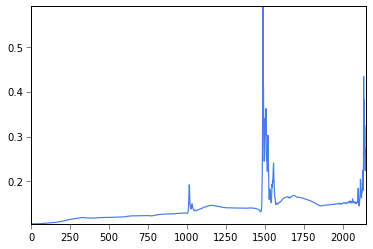

In [12]:
# we can use std to check the spik regions
plt.plot(np.nanstd(ncp_soil, axis=1))

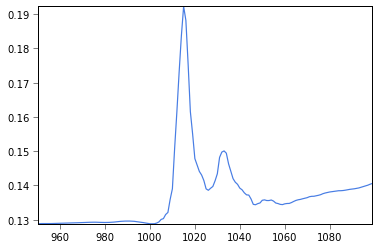

In [13]:
# the first absorbtion region
plt.plot(np.arange(950, 1100), np.nanstd(ncp_soil, axis=1)[950:1100])

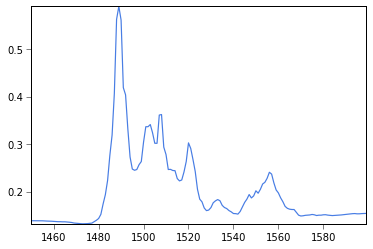

In [14]:
# the second absorbtion region
plt.plot(np.arange(1450, 1600), np.nanstd(ncp_soil, axis=1)[1450:1600])

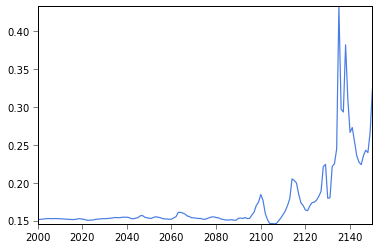

In [15]:
# the third absorbtion region
plt.plot(np.arange(2000, 2151), np.nanstd(ncp_soil, axis=1)[2000:2151])

So we can identify the regions where those spikes exist.

1. 1000-1060;
2. 1475-1580;
3. 2020-2151;

(0.0, 1.0)

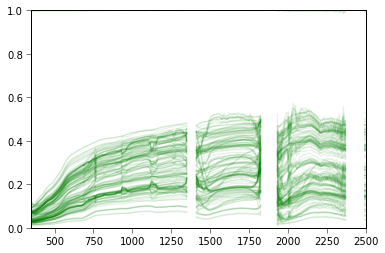

In [16]:
ncp_soil[1000:1060] = np.nan
ncp_soil[1475:1580] = np.nan
ncp_soil[2020:2151] = np.nan
# make sure there are some value at the end to avoid 
# unexpected interpolation
ncp_soil[-10:] = ncp_soil[2000:2010].mean(axis=0)
h = plt.plot(wv, ncp_soil, 'g-', alpha=0.1)
plt.ylim(0,1)

(0.0, 1.0)

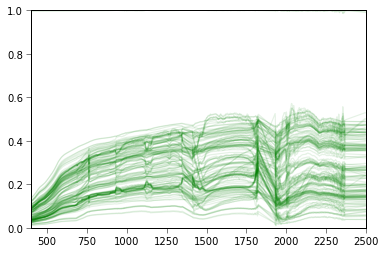

In [17]:
mask = np.all(np.isfinite(ncp_soil), axis=1)
f = interp1d(wv[mask], ncp_soil[mask].T, bounds_error=False)
xnew = np.arange(400, 2501, 1)
ynew = f(xnew)
ncp_soil = ynew
h = plt.plot(xnew, ncp_soil.T, 'g-', alpha=0.1)
plt.ylim(0,1)

### Putting them together

In [18]:
usgs_soil.shape, isricSoil.shape, prosail_soil.shape, price_soil.shape, ncp_soil.shape

((171, 2101), (1000, 2101), (538, 2101), (530, 2101), (168, 2101))

(0.0, 1.0)

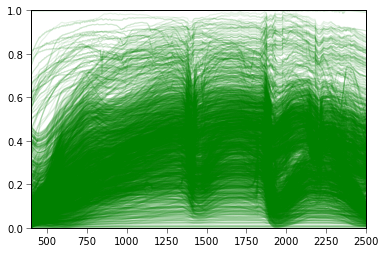

In [19]:
soils = np.vstack([usgs_soil, isricSoil, prosail_soil, price_soil, ncp_soil])
# all the soil samplled to 1 nm from 400-2500
wv = np.arange(400, 2501, 1)
h = plt.plot(wv, soils.T, 'g-', alpha=0.1)
plt.ylim(0,1)

#### PCA analysis

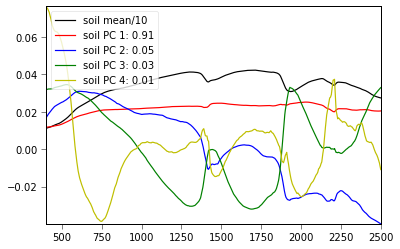

In [20]:
pca = PCA(n_components = 4).fit(soils)
ws  = pca.transform(soils)
soil_mean = pca.mean_
plt.plot(wv, pca.mean_/10, 'k-', label='soil mean/10')
plt.plot(wv, pca.components_[0], 'r-', label = 'soil PC 1: %.02f'%(pca.explained_variance_ratio_[0]))
plt.plot(wv, pca.components_[1], 'b-', label = 'soil PC 2: %.02f'%(pca.explained_variance_ratio_[1]))
plt.plot(wv, pca.components_[2], 'g-', label = 'soil PC 3: %.02f'%(pca.explained_variance_ratio_[2]))
plt.plot(wv, pca.components_[3], 'y-', label = 'soil PC 4: %.02f'%(pca.explained_variance_ratio_[3]))
plt.legend()

(0.0, 1.0)

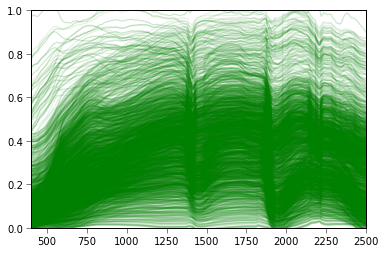

In [21]:
# constract soil from only 4 PCs
constrated_soil = np.dot(ws, pca.components_) + soil_mean
wv = np.arange(400, 2501, 1)
h = plt.plot(wv, constrated_soil.T, 'g-', alpha=0.1)
plt.ylim(0,1)

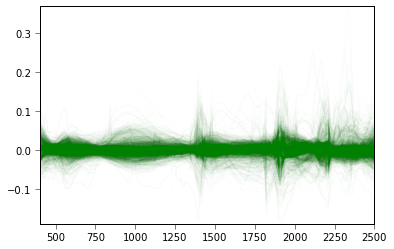

In [22]:
# the errors of constracted soil vs original soil
h = plt.plot(wv, (constrated_soil - soils).T, 'g-', alpha = 0.01)

As we can see, most of the errors are in the absorption regions, and some of them in the beginning and end of the spectra, where most of the assumpitons have been made about the spectra during interpolation.

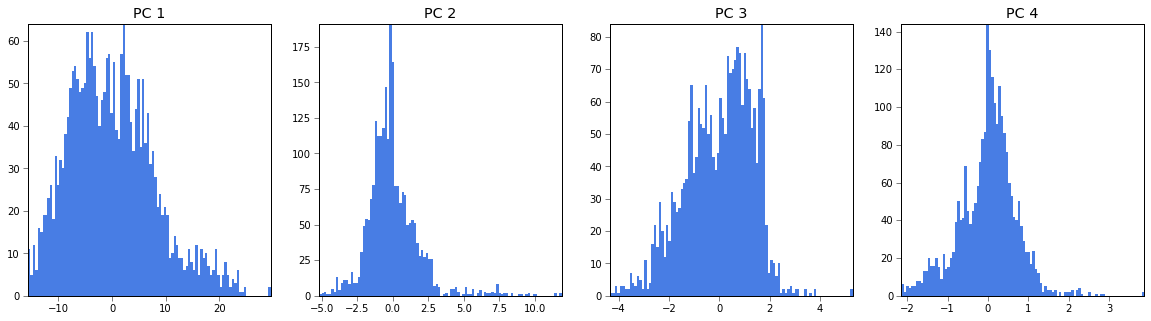

In [23]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize = (20, 5))
for i in range(4):
    h = axs[i].hist(ws[:,i], bins = 100)
    axs[i].set_title('PC %d'%(i + 1))


In [24]:
np.percentile(ws, 99, axis=0), np.percentile(ws, 1, axis=0)

(array([21.49592372,  7.34213183,  2.37284522,  1.79543724]),
 array([-14.43998918,  -3.85740788,  -3.41678845,  -1.81558917]))

In [25]:
# take the 99 percentile as the maximum
# and 1 percentile as the minimum
# to scale the original soil PC weights
# into between 0 and 1
ks  = np.percentile(ws, 99, axis=0) - np.percentile(ws, 1, axis=0)
bs  = np.percentile(ws, 1, axis=0)

def get_soil(p):
    p  = np.atleast_2d(p)
    pp = ks[None] * p + bs
    simu_soil = np.dot(pp, pca.components_) + soil_mean
    simu_soil[simu_soil<0] = 0    
    return simu_soil

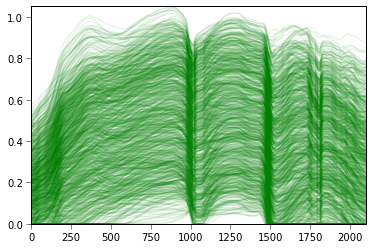

In [26]:
parameters = ['w1', 'w2', 'w3', 'w4']
p_mins =  [0] * 4
p_maxs =  [1] * 4
num_samp = 1000
# gp_emulator is only used to generate samples
# no actual emulation was made with it
sample, distributions = gp_emulator.create_training_set(parameters, p_mins, p_maxs, n_train=num_samp)
h = plt.plot(get_soil(sample).T, 'g-', alpha = 0.1)

In [27]:
# save them into file for later usage
np.savez('soils.npz', soils = soils, pcs = pca.components_, ws = ws, wv = wv, soil_mean = soil_mean)